Neural network takes data in csv form, as pair rgb, depth per line.

So we prepare data in required format and csv for them.

### converting files from tiff to jpg (RGB) and png (depth) and moving them to new folder

In [1]:
import glob
import os
from configparser import ConfigParser
import progressbar
from joblib import Parallel, delayed
from PIL import Image
import numpy as np
import csv
from visualization import load_depth
from gta_math import ndc_to_real, construct_proj_matrix, depth_to_integer_range, depth_crop_and_positive
from math import tan, atan, radians, degrees

In [2]:
def get_base_name(name):
    return os.path.basename(os.path.splitext(name)[0])


def convert_tiff(in_directory, out_directory, out_name, name, out_format, is_depth=False, transform=None):
    if 'pbar' in globals() and 'counter' in globals():
        global counter
        counter += 1
        pbar.update(counter)

    outfile = os.path.join(out_directory, "{}.{}".format(out_name, out_format))
    if os.path.exists(outfile):
        return

    try:
        infile = os.path.join(in_directory, name)
        # print('infile: ', infile)
        # print('is_depth: ', is_depth)
        # print('outfile: ', outfile)
        if is_depth:
            depth = load_depth(name)
            if transform is None:
                depth = depth * 255.0
                im = Image.fromarray(depth.astype(np.uint8), mode="L")
            else:
                H = transform['H']
                W = transform['W']
                fov = transform['fov']
                near_clip = transform['near_clip']
                depth = ndc_to_real(depth, construct_proj_matrix(H, W, fov, near_clip))
                depth = depth_crop_and_positive(depth)
                depth = depth_to_integer_range(depth)
                im = Image.fromarray(depth, mode="I")  # I is mode for int32 single valued image, but using only uint16 which fits into png
        else:
            im = Image.open(infile)
            im = im.convert(mode="RGB")
        # print("Generating new format for {} to new file {}".format(name, out_name))
        im.save(outfile)
    except OSError:
        # print("Skipping invalid file {}".format(name))
        return


def tiff_to_dataset(in_directory, out_directory, name, rgb_format, depth_format):
    convert_tiff(in_directory, out_directory, get_base_name(name), get_base_name(name)+'.tiff', rgb_format, is_depth=False)
    convert_tiff(in_directory, out_directory, get_base_name(name), get_base_name(name), depth_format, is_depth=True)


def tiff_to_dataset_with_transform(in_directory, out_directory, name, rgb_format, depth_format, transform):
    convert_tiff(in_directory, out_directory, get_base_name(name), get_base_name(name)+'.tiff', rgb_format, is_depth=False)
    convert_tiff(in_directory, out_directory, get_base_name(name), get_base_name(name), depth_format, is_depth=True, transform=transform)


In [3]:
ini_file = "gta-postprocessing.local.ini"

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = CONFIG["Images"]["Tiff"]
out_directory = CONFIG["Images"]["MlDataset"]
out_root_directory = 'D:\projekty\GTA-V-extractors\depthEstimationNN1'

rgb_format = 'jpg'
depth_format = 'png'

import visualization
visualization.multi_page = False
visualization.ini_file = ini_file


## for raw files, in NDC, without db

In [ ]:
workers = 10
pattern = '[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9]-[0-9][0-9]-[0-9][0-9]--[0-9][0-9][0-9].tiff'

widgets = [progressbar.Percentage(), ' ', progressbar.Counter(), ' ', progressbar.Bar(), ' ',
           progressbar.FileTransferSpeed()]

files = glob.glob(os.path.join(in_directory, pattern))

pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(files) * 2).start()
counter = 0

Parallel(n_jobs=workers, backend='threading')(delayed(tiff_to_dataset)(in_directory, out_directory, name, rgb_format, depth_format)
                         for name in files)


## for transformation from NDC to world, with db

In [ ]:
workers = 10

run_id = 6

widgets = [progressbar.Percentage(), ' ', progressbar.Counter(), ' ', progressbar.Bar(), ' ',
           progressbar.FileTransferSpeed()]

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, camera_fov, width, height, cam_near_clip \
    FROM snapshots \
    WHERE run_id = {} \
    ORDER BY snapshot_id DESC \
    """.format(run_id))

results = [dict(res) for res in cur]
#files = [os.path.join(in_directory, i['imagepath']) for i in results]
records = [(os.path.join(in_directory, i['imagepath']), 
            {'H': i['height'], 'W': i['width'], 'fov': i['camera_fov'], 'near_clip': i['cam_near_clip']}) for i in results]


pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(records) * 2).start()
counter = 0

Parallel(n_jobs=workers, backend='threading')(delayed(tiff_to_dataset_with_transform)
                                              (in_directory, out_directory, name, rgb_format, depth_format, transform)
                         for name, transform in records)


In [ ]:
files = glob.glob(os.path.join(in_directory, pattern))

filenames = []
for i, name in enumerate(files):
    rgb_name = "{}.{}".format(get_base_name(name), rgb_format)
    rgb_name = os.path.relpath(os.path.join(out_directory, rgb_name), start=out_root_directory)
    rgb_name = rgb_name.replace('\\', '/')
    depth_name = "{}.{}".format(get_base_name(name), depth_format)
    depth_name = os.path.relpath(os.path.join(out_directory, depth_name), start=out_root_directory)
    depth_name = depth_name.replace('\\', '/')
    filenames.append([rgb_name, depth_name])

    # r je abych nemusel psát zpětná lomítka
with open(os.path.join(out_root_directory, 'train-gta.csv'), 'w+', newline='') as f:
    csv.writer(f).writerows(filenames)


### trying for one image

In [4]:
run_id = 6

conn = visualization.get_connection()
cur = conn.cursor()
cur.execute("""SELECT snapshot_id, imagepath, camera_fov, width, height, cam_near_clip \
    FROM snapshots \
    WHERE run_id = {} \
    ORDER BY snapshot_id DESC \
    """.format(run_id))

results = [dict(res) for res in cur]
#files = [os.path.join(in_directory, i['imagepath']) for i in results]
records = [(os.path.join(in_directory, i['imagepath']), 
            {'H': i['height'], 'W': i['width'], 'fov': i['camera_fov'], 'near_clip': i['cam_near_clip']}) for i in results]

name, transform = records[0]
tiff_to_dataset_with_transform(in_directory, out_directory, name, rgb_format, depth_format, transform)

In [5]:
name, transform = records[0]
name = get_base_name(name)
out_name = get_base_name(name)

infile = os.path.join(in_directory, name)
# print('infile: ', infile)
# print('is_depth: ', is_depth)
# print('outfile: ', outfile)
depth = load_depth(name)
H = transform['H']
W = transform['W']
fov = transform['fov']
near_clip = transform['near_clip']


In [6]:
import time

start = time.time()
depth = ndc_to_real(depth, construct_proj_matrix(H, W, fov, near_clip))
end = time.time()
print('time to convert coords: ', end - start)
depth = depth_crop_and_positive(depth)
print('depth calculated')


time to generate_points:  0.0179901123046875
time to prepare treshold:  0.061995744705200195
time to transfer all points to ndcs:  0.026000499725341797
time to transfer all pixels to homo:  0.03300118446350098
time to points_to_homo:  0.12599635124206543
time to ndc_to_view:  0.0650014877319336
time to extract to new depth:  1.9830005168914795
time to convert coords:  2.2039880752563477
depth calculated


In [7]:
out_format = 'png'
outfile = os.path.join(out_directory, "{}.{}".format(out_name, out_format))

# whole conversion
import gta_math
gta_math.MAXIMUM = np.iinfo(np.uint16).max
depth_int = depth_to_integer_range(depth)

print(np.min(depth_int))
print(np.max(depth_int))
print(np.iinfo(np.int16).min)
print(np.iinfo(np.int16).max)

# import png
# f = open(outfile, 'wb')      # binary mode is important
# w = png.Writer(depth_int.shape[1], depth_int.shape[0], greyscale=True, bitdepth=16)
# w.write(f, depth_int)
# f.close()

im = Image.fromarray(depth_int, mode="I")  # I is mode for int32 single valued image
print('image created')
# print("Generating new format for {} to new file {}".format(name, out_name))
im.save(outfile)
print('file saved')

135
65535
-32768
32767
image created
file saved


int32
135
65535
2.05997
1000.0


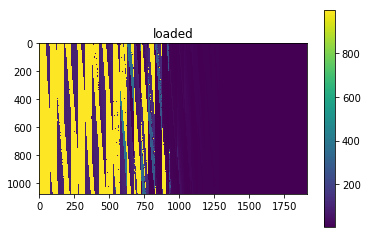

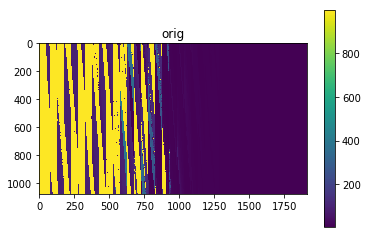

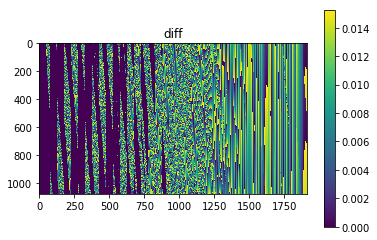

mean difference:  0.00566201
max difference:  0.0152588


In [8]:
from gta_math import depth_from_integer_range
import matplotlib.pyplot as plt

im = Image.open(outfile)
im_arr = np.array(im)
print(im_arr.dtype)
print(np.min(im_arr))
print(np.max(im_arr))

im_arr = depth_from_integer_range(im_arr)
print(np.min(im_arr))
print(np.max(im_arr))

im_arr = im_arr.reshape(depth.shape[0], depth.shape[1])
%matplotlib inline
plt.figure()
plt.title('loaded')
ii = plt.imshow(im_arr)
plt.colorbar(ii)

plt.figure()
plt.title('orig')
ii = plt.imshow(depth)
plt.colorbar(ii)

plt.figure()
plt.title('diff')
ii = plt.imshow(depth - im_arr)
plt.colorbar(ii)

plt.show()
print('mean difference: ', np.mean(np.abs(depth - im_arr)))
print('max difference: ', np.max(np.abs(depth - im_arr)))

### inspecting conversion one step at a time

In [ ]:
THRESHOLD = 1000
MAXIMUM = np.iinfo(np.uint16).max
# then we treshold the far clip so when we scale to integer range
depth_threshold = np.copy(depth)
depth_threshold[depth_threshold > THRESHOLD] = THRESHOLD
ratio = MAXIMUM / THRESHOLD
depth_integer = depth_threshold * ratio
depth_integer_rounded = depth_integer.astype(np.int32)


In [ ]:

%matplotlib inline
plt.figure(figsize=(10, 10))
plt.title('loaded image')
ii = plt.imshow(im_arr)
plt.colorbar(ii)

plt.figure(figsize=(10, 10))
plt.title('depth')
ii = plt.imshow(depth)
plt.colorbar(ii)

plt.figure(figsize=(10, 10))
plt.title('depth_threshold')
ii = plt.imshow(depth_threshold)
plt.colorbar(ii)

plt.figure(figsize=(10, 10))
plt.title('depth_integer')
ii = plt.imshow(depth_integer)
plt.colorbar(ii)

plt.figure(figsize=(10, 10))
plt.title('depth_integer_rounded')
ii = plt.imshow(depth_integer_rounded)
plt.colorbar(ii)

plt.figure(figsize=(10, 10))
plt.title('depth int')
ii = plt.imshow(depth_int)
plt.colorbar(ii)
plt.show()

In [ ]:
print(np.min(im_arr))
print(np.max(im_arr))

%matplotlib inline
plt.figure(figsize=(13, 13))
plt.title('depth from file')
plt.yscale('log', nonposy='clip')
plt.hist(im_arr.reshape(-1, 1), 100)

plt.figure(figsize=(13, 13))
plt.title('depth')
plt.yscale('log', nonposy='clip')
plt.hist(depth.reshape(-1, 1), 100)

plt.figure(figsize=(13, 13))
plt.title('depth_threshold')
plt.yscale('log', nonposy='clip')
plt.hist(depth_threshold.reshape(-1, 1), 100)

plt.figure(figsize=(13, 13))
plt.title('depth_integer')
plt.yscale('log', nonposy='clip')
plt.hist(depth_integer.reshape(-1, 1), 100)

plt.figure(figsize=(13, 13))
plt.title('depth_integer_rounded')
plt.yscale('log', nonposy='clip')
plt.hist(depth_integer_rounded.reshape(-1, 1), 100)

plt.show()